In this workbook I will attempt to quantify and visualise which player statistics voters take into account when deciding who should win the NBAs Most Improved Player award.

By looking at the previous ten winners of the award and the statistics that contribute to them winning the award, I can calculate the same statistics for the current NBA season in an attempt to predict the winner of the award for this year.

In [1]:
#Import necessary libraries
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date

In [2]:
def get_season_data(year):
    """
    Takes a year as input and returns a Pandas dataframe of every NBA players season stats for that year.
    """
    url_prefix = "https://www.basketball-reference.com/leagues/NBA_"
    url_suffix = "_per_game.html"
    url = url_prefix + str(year) + url_suffix
    
    html = urlopen(url)
    
    soup = bs(html, features="lxml")
    
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')][1:]
    
    rows = soup.findAll('tr')[1:]
    rows_data = [[td.getText() for td in rows[i].findAll('td')] for i in range(len(rows))]
    
    return pd.DataFrame(rows_data,columns=headers).dropna()

In [3]:
#define a function that takes in the dataframe above and 
#returns it without duplicate player entries for multiple teams
def drop_duplicate_players(df):
    """
    Takes a Pandas dataframe of an NBA seasons individual player stats
    and removes all duplicate entries for players who played for more than one team.
    Only shows these players total season averages, not their individual team averages,
    """
    players_with_mult_teams = df[df['Tm']=='TOT']['Player']
    
    #Get a df of only these players
    players_with_mult_teams_totals = df[(df['Player'].isin(players_with_mult_teams)) & 
                                           (df['Tm']=='TOT')]
    
    #Get a df with only players who played for one team in the season
    players_with_single_team_totals = df[~df['Player'].isin(players_with_mult_teams)]
    
    #combine both dataframes to get player totals for the season
    new_df = pd.concat([players_with_mult_teams_totals, 
                            players_with_single_team_totals]).sort_values(by='Player').reset_index(drop=True)
    
    return new_df

In [4]:
#Get a list of the previous ten NBA seasons
previous_seasons = list(range(2021,2011,-1))
previous_seasons

[2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012]

In [5]:
#Get a list of previous MIP winners each year
historical_winners = {2021: ['Julius Randle'],
                     2020: ['Brandon Ingram'],
                     2019: ['Pascal Siakam'],
                     2018: ['Victor Oladipo'],
                     2017: ['Giannis Antetokounmpo'],
                     2016: ['CJ McCollum'],
                     2015: ['Jimmy Butler'],
                     2014: ['Goran Dragić'],
                     2013: ['Paul George'],
                     2012: ['Ryan Anderson']}

In [6]:
#Get lists of first-time all stars by year
first_time_allstars = {2021: ['Jaylen Brown', 
                             'Zion Williamson',
                             'Julius Randle',
                             'Zach LaVine'],
                      2020: ['Trae Young',
                            'Luka Dončić',
                            'Pascal Siakam',
                            'Donovan Mitchell',
                            'Rudy Gobert',
                            'Jayson Tatum',
                            'Brandon Ingram',
                            'Bam Adebayo',
                            'Domantas Sabonis',
                            'Devin Booker'],
                      2019: ['Ben Simmons',
                            'Nikola Jokić',
                            'Khris Middleton',
                            'Nikola Vučević',
                            "D'Angelo Russell"],
                      2018: ['Joel Embiid',
                            'Karl-Anthony Towns',
                            'Victor Oladipo',
                            'Goran Dragić',
                            'Bradley Beal',
                            'Kristaps Porziņģis'],
                      2017: ['Giannis Antetokounmpo',
                            'Gordon Hayward',
                            'DeAndre Jordan',
                            'Kemba Walker'],
                      2016: ['Kawhi Leonard',
                            'Draymond Green',
                            'Isaiah Thomas',
                            'Andre Drummond'],
                      2015: ['Klay Thompson',
                            'DeMarcus Cousins',
                            'Jimmy Butler',
                            'Kyle Lowry',
                            'Kyle Korver',
                            'Jeff Teague'],
                      2014: ['Anthony Davis',
                            'Stephen Curry',
                            'DeMar DeRozan',
                            'John Wall',
                            'Paul Millsap',
                            'Damian Lillard'],
                      2013: ['James Harden',
                            'Kyrie Irving',
                            'Paul George',
                            'Joakim Noah',
                            'Tyson Chandler',
                            'Jrue Holiday',
                            'Brook Lopez'],
                      2012: ['Marc Gasol',
                            'LaMarcus Aldridge',
                            'Roy Hibbert',
                            'Luol Deng',
                            'Andrew Bynum',
                            'Andre Iguodala']}

In [7]:
#Create a dictionary where the keys are the years of the previous ten NBA seasons, and the values are the
#Pandas dataframes of a series of statistics that may quantify a players improvement year-on-year
year_dataframes = {}

#Loop through the last ten years
for year in previous_seasons:
    #Get both dataframes of all players stats
    current_year = get_season_data(year)
    current_year = drop_duplicate_players(current_year)
    
    previous_year = get_season_data(year-1)
    previous_year = drop_duplicate_players(previous_year)
    
    #Only show players who are 27 and under, as the award is generally given to young up-and-coming players
    current_year = current_year[current_year['Age'].astype(int) <= 27]
    
    #Only show players who score at least 12 ppg, as the award has only gone to these players in the last 20 years
    current_year = current_year[current_year['PTS'].astype(float) > 12]
    
    #Only show players who played at least 25 games
    current_year = current_year[current_year['G'].astype(int) >= 25]
    
    #Get a list of players that have played in both seasons
    mip_candidates = []
    for player in list(current_year['Player']):
        if player in list(previous_year['Player']):
            mip_candidates.append(player)
            
    #filter both dataframes to contain only players eligible for MIP award
    current_year = current_year[current_year['Player'].isin(mip_candidates)].reset_index(drop=True)
    previous_year = previous_year[previous_year['Player'].isin(mip_candidates)].reset_index(drop=True)

    
    
    #Calculate this years improvement stats and rank
    data = {'Player': mip_candidates, 'PPG_Ratio': [],'Mins_Ratio': [], 'PPG': [], 'Norm_PPG_Ratio': []}
    
    #PPG Ratio = current year points per game / previous year points per game
    #Mins Ratio = current year minutes per game / previous year minutes per game
    #PPG = current year points per game
    #Norm PPG Ratio = PPG Ratio normalised by dividing by Mins ratio
    
    for player in mip_candidates:
        #Two players called Chris Johnson played in one year which was causing an error, can ignore both players
        if player == 'Chris Johnson':
            data['PPG_Ratio'].append(np.nan)
            data['Mins_Ratio'].append(np.nan)
            data['PPG'].append(np.nan)
            data['Norm_PPG_Ratio'].append(np.nan)
            continue
     
        #Get the current and previous year points and mins per game
        ppg_current = round(float(current_year[current_year['Player']==player]['PTS']),2)
        ppg_previous = round(float(previous_year[previous_year['Player']==player]['PTS']),2)
        
        mpg_current = round(float(current_year[current_year['Player']==player]['MP']),2)
        mpg_previous = round(float(previous_year[previous_year['Player']==player]['MP']),2)
        
        #If their mins or ppg in previous year were < 0.1 then continue
        if ppg_previous < 0.1:
            data['PPG_Ratio'].append(np.nan)
            data['Mins_Ratio'].append(np.nan)
            data['PPG'].append(ppg_current)
            data['Norm_PPG_Ratio'].append(np.nan)
            continue
        if mpg_previous < 0.1:
            data['PPG_Ratio'].append(np.nan)
            data['Mins_Ratio'].append(np.nan)
            data['PPG'].append(ppg_current)
            data['Norm_PPG_Ratio'].append(np.nan)
            continue
        
        #Calculate PPG and Mins ratios
        ppg_ratio = ppg_current / ppg_previous
        mins_ratio = mpg_current / mpg_previous
        
        #Calculate normalised PPG ratio
        norm_ppg_ratio = ppg_ratio / mins_ratio
        
        #Add data to dataset
        data['PPG_Ratio'].append(ppg_ratio)
        data['Mins_Ratio'].append(mins_ratio)
        data['PPG'].append(ppg_current)
        data['Norm_PPG_Ratio'].append(norm_ppg_ratio)
    
    #Create dataframe from dataset
    ratio_data = pd.DataFrame.from_dict(data)
    
    #Calculate an improvement score which is:
    #PPG ratio multiplied by current year PPG
    #This weights the score higher for players who have a higher points per game, as the award tends to reward
    #Players who are making the jump to a higher standard.
    #E.G improving by 10 PPG from 15 to 25 is generally regarded higher than moving from 5 to 15 PPG
    ratio_data['Improvement_Score'] = ratio_data['PPG_Ratio'] * ratio_data['PPG']
    
    #Normalise the improvement score by dividing by the mins ratio
    ratio_data['Normalised_Improvement_Score'] = ratio_data['Improvement_Score'] / ratio_data['Mins_Ratio']
    
    #Boolean for first time allstars
    ratio_data['First_Allstar'] = ratio_data['Player'].isin(first_time_allstars[year])
    
    #Boolean for winner of Most Improved Player
    ratio_data['MIP'] = ratio_data['Player'].isin(historical_winners[year])
    
    ratio_data = ratio_data.sort_values(by='Normalised_Improvement_Score',ascending=False).reset_index(drop=True)
    
    #Insert calculated data into the years dictionary
    year_dataframes[year] = ratio_data

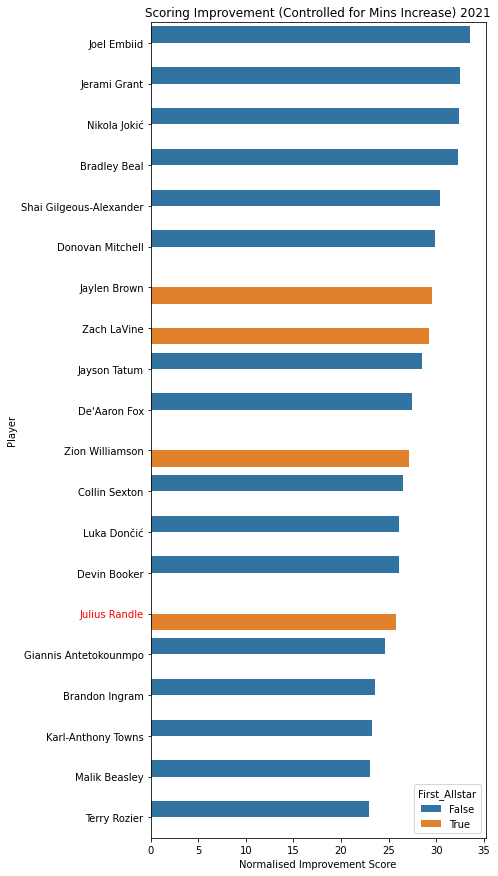

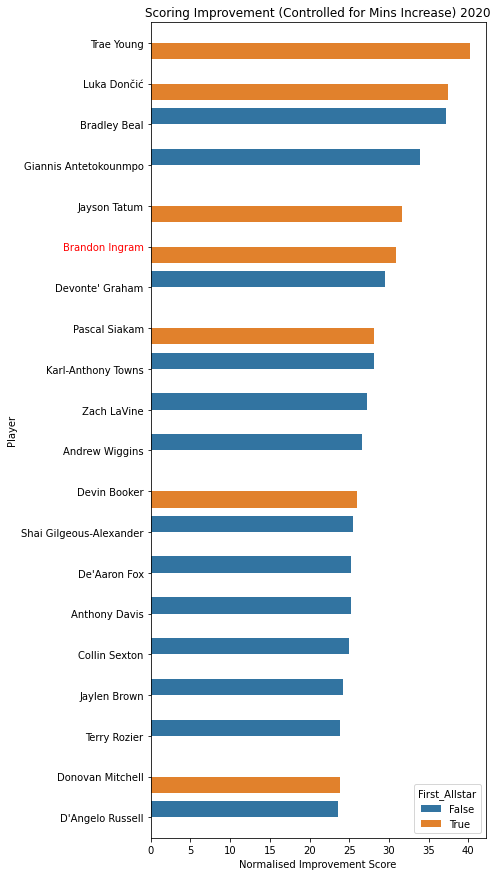

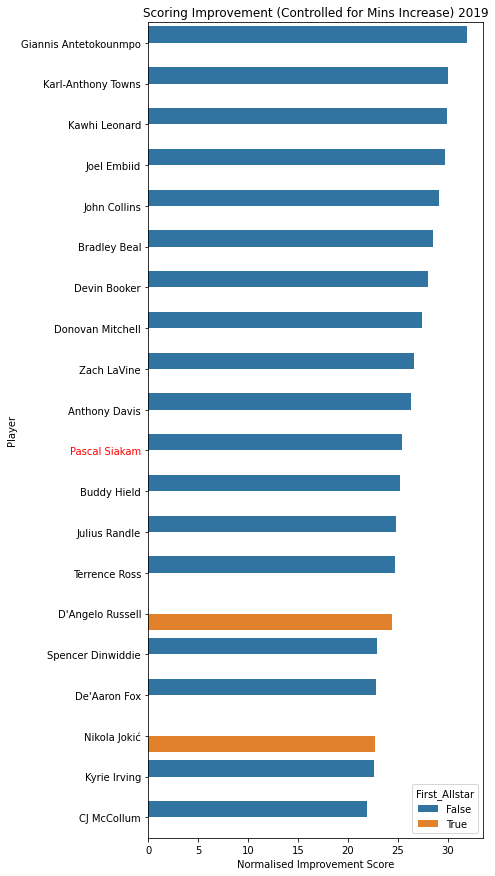

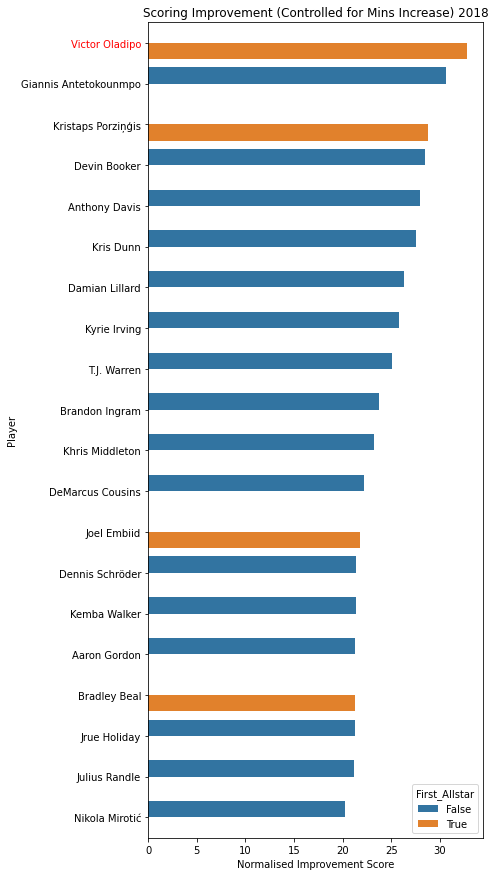

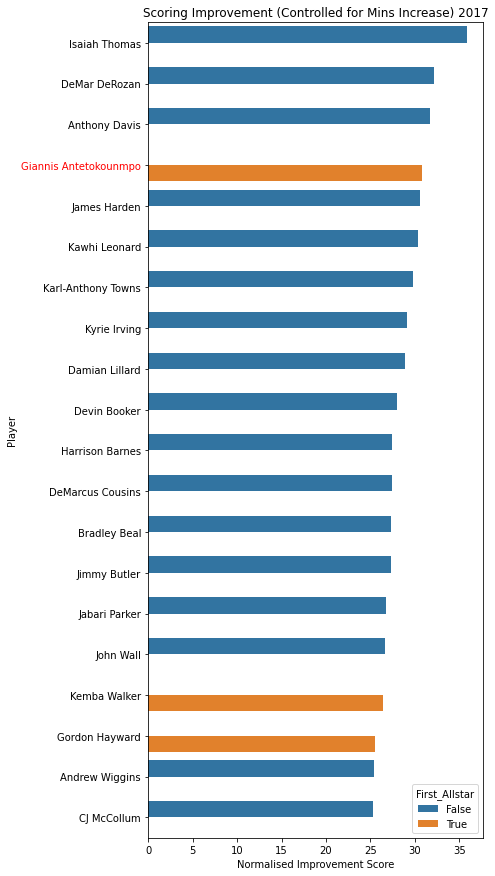

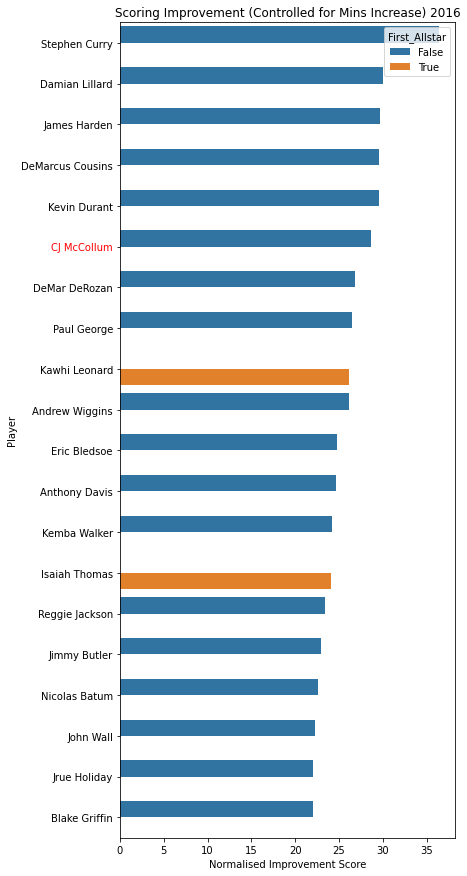

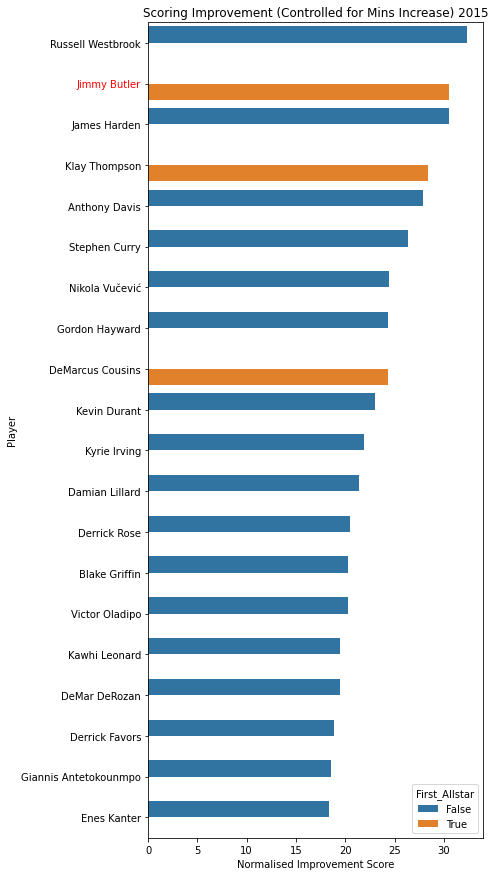

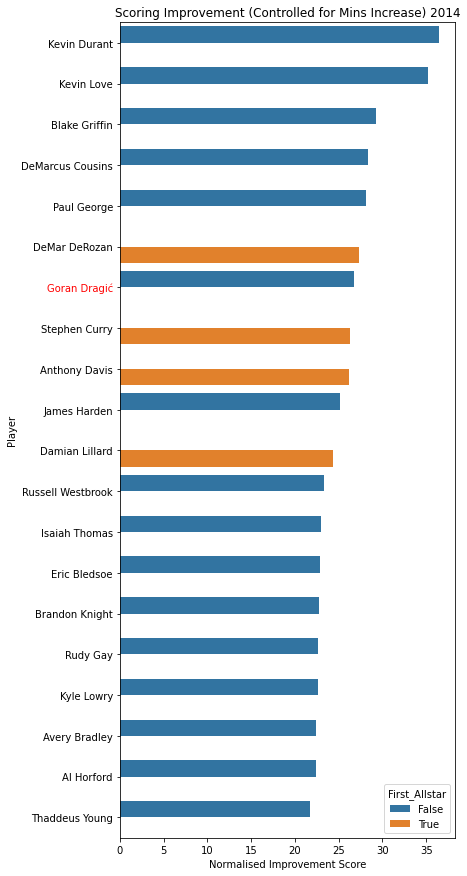

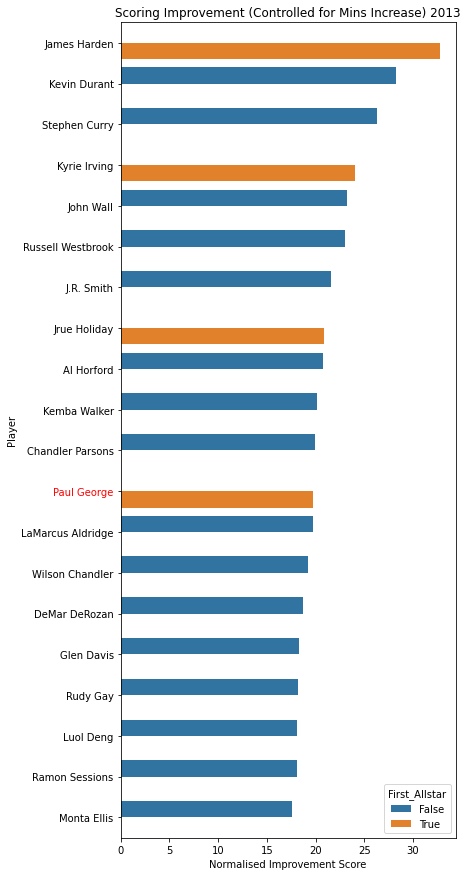

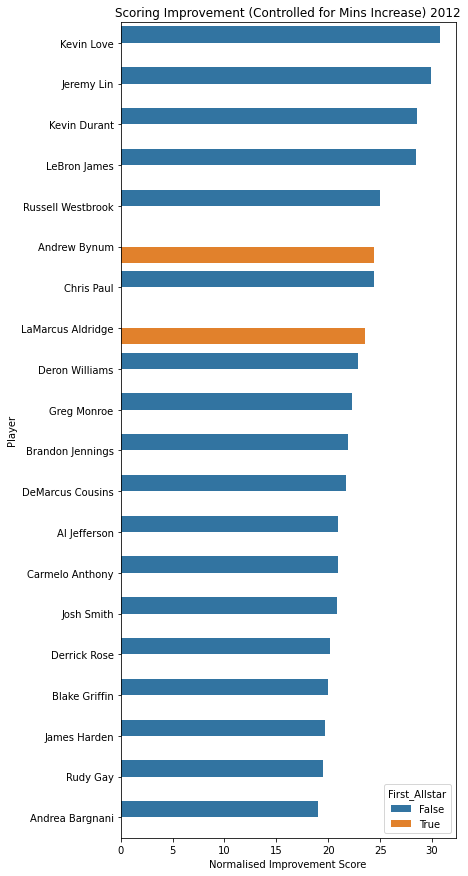

In [8]:
#Visualise the Normalised Improvement Score for the last 10 years
#Highlighting the players who were first time all stars in a different bar colour
#Highlighting the player who won the MIP award in red font
for year in year_dataframes.keys():
    plt.figure(figsize=(6,15))
    
    ax1 = sns.barplot(x='Normalised_Improvement_Score',y='Player',data=year_dataframes[year].head(20),hue='First_Allstar')
    
    plt.title('Scoring Improvement (Controlled for Mins Increase) ' + str(year))
    plt.xlabel('Normalised Improvement Score')
    
    #If a player won the MIP award for that year, highlight them in red font on the y-axis
    for (MIP, ticklbl) in zip(year_dataframes[year]['MIP'], ax1.yaxis.get_ticklabels()):
        ticklbl.set_color('red' if MIP == 1 else 'black')
        
    plt.show()

The ten plots above show that Normalised Improvement Score is a decent metric for predicting success in the Most Improved Player award, however it cannot be used alone to predict the winner.

Being a first time all-star does seem to have a correlation with winning the award as six of the last ten winners were first time all-stars.

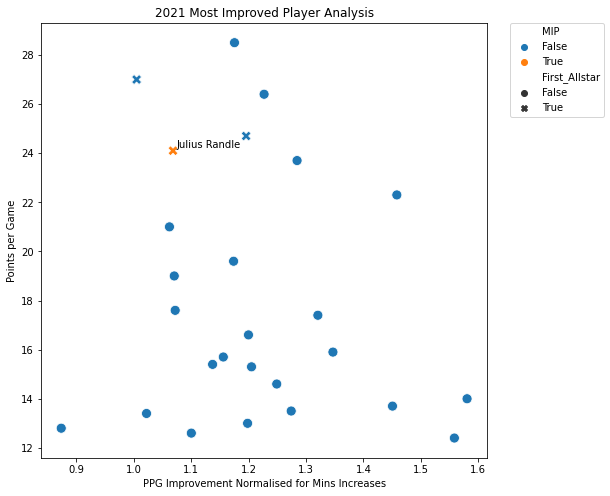

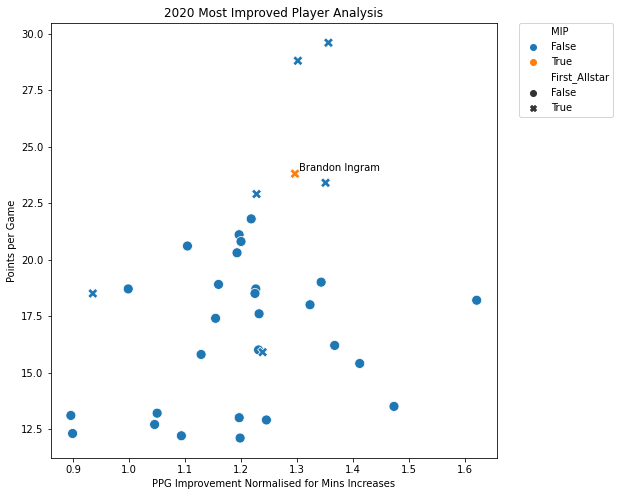

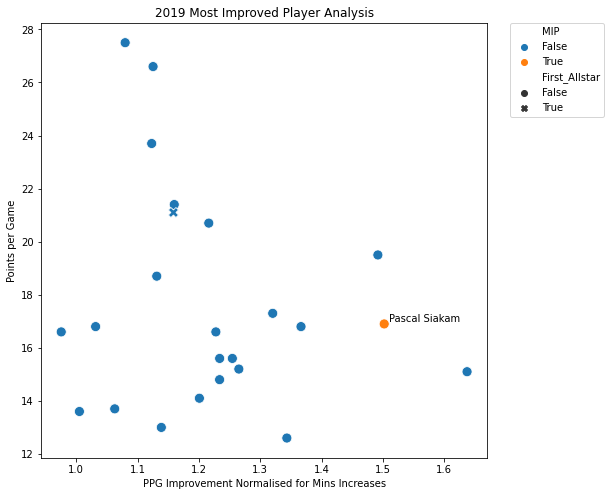

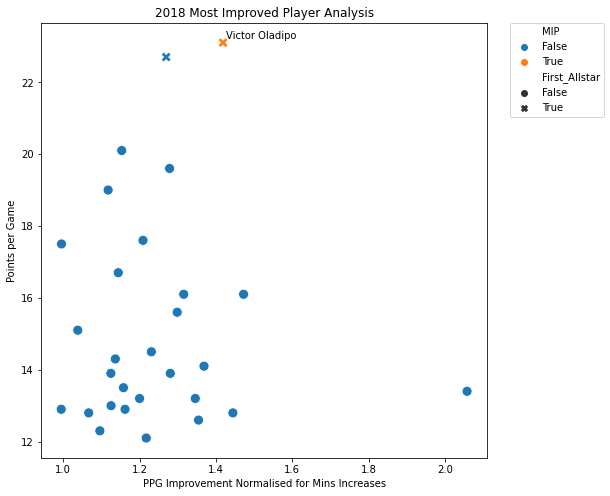

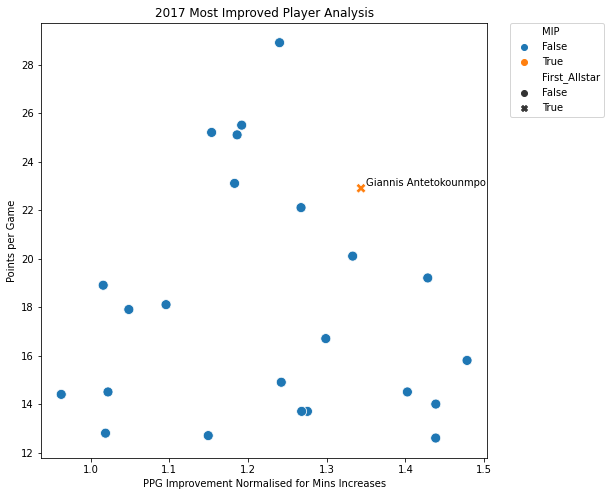

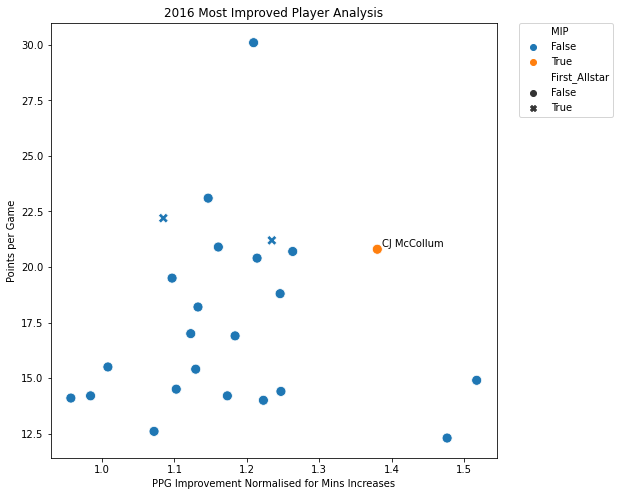

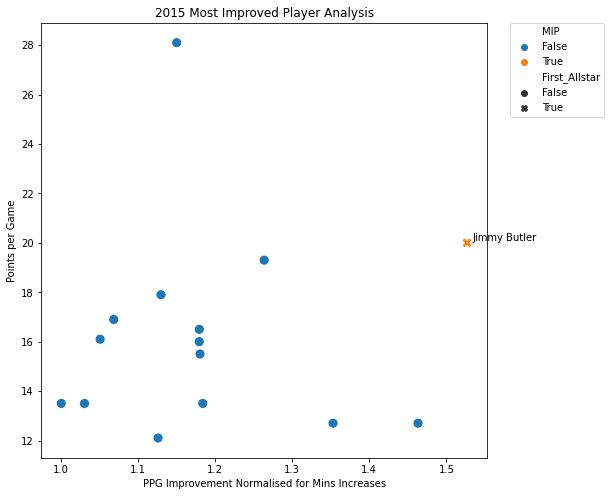

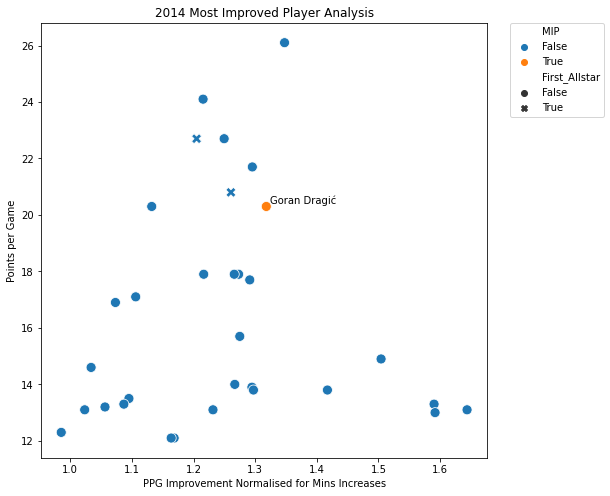

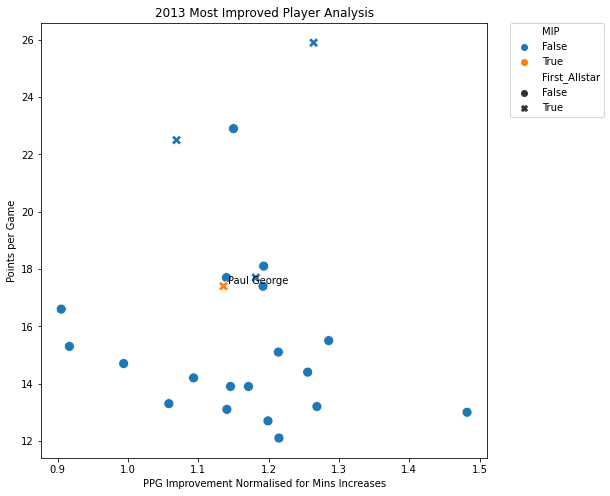

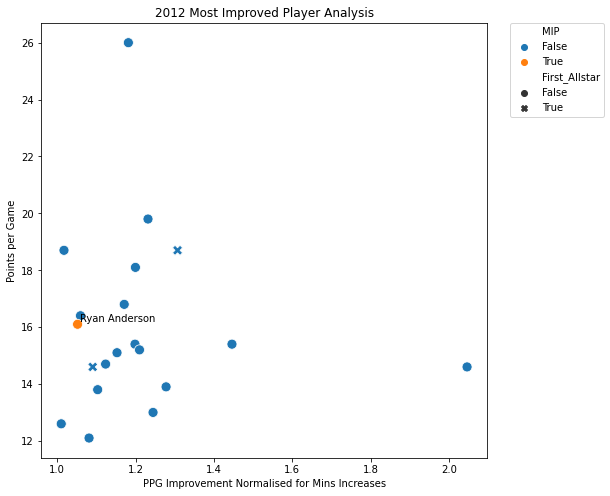

In [9]:
#Plot the last ten years of MIP data as scatterplots
#With Normalised PPG ratios on the x axis and current year PPG on the y-axis
#Highlight the winner of the MIP award that year in a different colour
#Highlight first time all-stars that year in a different marker
for year in year_dataframes.keys():
    
    #Only show players with a PPG improvement ratio of at least 1.2
    df = year_dataframes[year][year_dataframes[year]['PPG_Ratio'] >= 1.2].reset_index(drop=True)
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x='Norm_PPG_Ratio',y='PPG',data=df,s=100,hue='MIP',style='First_Allstar')
    
    #Find the data of the MIP winner
    winner_index = df[df['MIP']==1].index
    
    #Label the MIP winner with text on the chart
    plt.text(np.array(df.iloc[winner_index]['Norm_PPG_Ratio'])[0]*1.005,
             np.array(df.iloc[winner_index]['PPG'])[0]*1.005,
            np.array(df.iloc[winner_index]['Player'])[0])
    
    #Label axis and title
    plt.xlabel('PPG Improvement Normalised for Mins Increases')
    plt.ylabel('Points per Game')
    plt.title(str(year) + ' Most Improved Player Analysis')
    
    #Put the legend outside the chart
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

On these scatter charts, the Most Improved Player each year does tend to be places towards the top-right side of the chart. 

Visualising this chart for the current year could show us where players stand in the current race to win the Most Improved Player award.

In [10]:
#Use the same code as before but entering the 2022 and 2021 NBA seasons to look at the current year

#Get both dataframes of all players stats
current_year = get_season_data(2022)
current_year = drop_duplicate_players(current_year)

previous_year = get_season_data(2021)
previous_year = drop_duplicate_players(previous_year)

#Only show players who are 27 and under
current_year = current_year[current_year['Age'].astype(int) <= 27]

#Only show players who score at least 12 ppg
current_year = current_year[current_year['PTS'].astype(float) > 12]

#Get a list of players that have played in both seasons
mip_candidates = []
for player in list(current_year['Player']):
    if player in list(previous_year['Player']):
        mip_candidates.append(player)

#filter both dataframes to contain only players eligible for MIP award
current_year = current_year[current_year['Player'].isin(mip_candidates)].reset_index(drop=True)
previous_year = previous_year[previous_year['Player'].isin(mip_candidates)].reset_index(drop=True)


#Calculate this years improvement stats and rank
data = {'Player': mip_candidates, 'PPG_Ratio': [],'Mins_Ratio': [], 'PPG': [], 'Norm_PPG_Ratio': []}
for player in mip_candidates:
    if player == 'Chris Johnson':
        data['PPG_Ratio'].append(np.nan)
        data['Mins_Ratio'].append(np.nan)
        data['PPG'].append(np.nan)
        data['Norm_PPG_Ratio'].append(np.nan)
        continue

    #If their mins or ppg in previous year were 0 then continue      
    ppg_current = round(float(current_year[current_year['Player']==player]['PTS']),2)
    ppg_previous = round(float(previous_year[previous_year['Player']==player]['PTS']),2)

    mpg_current = round(float(current_year[current_year['Player']==player]['MP']),2)
    mpg_previous = round(float(previous_year[previous_year['Player']==player]['MP']),2)

    if ppg_previous < 0.1:
        data['PPG_Ratio'].append(np.nan)
        data['Mins_Ratio'].append(np.nan)
        data['PPG'].append(ppg_current)
        data['Norm_PPG_Ratio'].append(np.nan)
        continue
    if mpg_previous < 0.1:
        data['PPG_Ratio'].append(np.nan)
        data['Mins_Ratio'].append(np.nan)
        data['PPG'].append(ppg_current)
        data['Norm_PPG_Ratio'].append(np.nan)
        continue

    ppg_ratio = ppg_current / ppg_previous
    mins_ratio = mpg_current / mpg_previous

    norm_ppg_ratio = ppg_ratio / mins_ratio

    data['PPG_Ratio'].append(ppg_ratio)
    data['Mins_Ratio'].append(mins_ratio)
    data['PPG'].append(ppg_current)
    data['Norm_PPG_Ratio'].append(norm_ppg_ratio)

ratio_data = pd.DataFrame.from_dict(data)
ratio_data['Improvement_Score'] = ratio_data['PPG_Ratio'] * ratio_data['PPG']
ratio_data['Normalised_Improvement_Score'] = ratio_data['Improvement_Score'] / ratio_data['Mins_Ratio']

#Boolean for first time allstars
ratio_data['First_Allstar'] = ratio_data['Player'].isin(first_time_allstars[year])

#Boolean for winner of Most Improved Player
ratio_data['MIP'] = ratio_data['Player'].isin(historical_winners[year])

ratio_data = ratio_data.sort_values(by='Normalised_Improvement_Score',ascending=False).reset_index(drop=True)

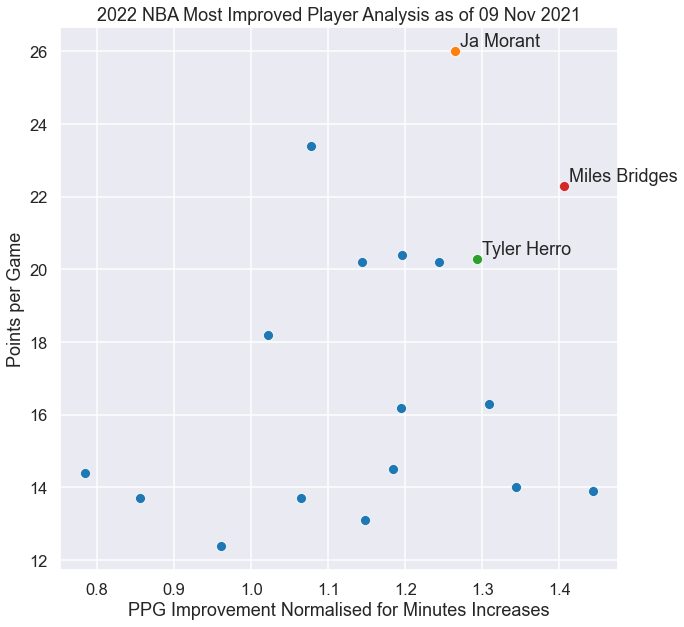

In [11]:
#Set the style of the plot that is generated
sns.set_context('talk')
sns.set_style('darkgrid')

#Only look at players with a PPG Improvement Ratio of at least 1.2
df = ratio_data[ratio_data['PPG_Ratio'] >= 1.2].reset_index(drop=True)

plt.figure(figsize=(10,10))

#Plot the data
sns.scatterplot(x='Norm_PPG_Ratio',y='PPG',data=df,s=100)

#Take the top three favourites from the betting market and note them on the plot
players_of_note = ['Ja Morant','Tyler Herro','Miles Bridges']

for player in players_of_note:
    player_index = df[df['Player']==player].index
    player_data = df[df['Player']==player]
    
    #Plot the player in a different colour
    sns.scatterplot(x='Norm_PPG_Ratio',y='PPG',data=player_data,s=100)
    
    #Label the player on the plot
    plt.text(np.array(df.iloc[player_index]['Norm_PPG_Ratio'])[0]*1.005,
             np.array(df.iloc[player_index]['PPG'])[0]*1.005,
             np.array(df.iloc[player_index]['Player'])[0])

#Label the graph
plt.xlabel('PPG Improvement Normalised for Minutes Increases')
plt.ylabel('Points per Game')
today = date.today().strftime('%d %b %Y')
plt.title(str(2022) + ' NBA Most Improved Player Analysis as of ' + today)
plt.tight_layout

#Save a copy of todays standings to compare over time
plt.savefig('MIP Analysis ' + today, bbox_inches='tight')

From the graph above, it is obvious that Ja Moran and Miles Bridges are deservedly the two favourites for the award in the betting markets. Tyler Herro is the third favourite but his statistics are tightly grouped with a further three players and so in my opinion he is unlikely to win the award.

Ja Morant is much more likely than Miles Bridges to be voted in as a first-time all-star this year and so in my opinion he is much more likely to win the NBA Most Improved Player award.